In [6]:
import os
import regex
import textstat

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
papersDir = "data/pmc_txt"
outFile = "results/textstat.results.tsv"

In [12]:
#Calculates the Flesch-Kincaid Grade Level, Gunning FOG Index, Automated Readability Index and Coleman-Liau Index
#for the given text. Writes results to an outpul tsv file.


def calcReadabilityScores(content, basename, stats=[], outFile=""):
    stats.append([basename, "flesch_reading_ease", textstat.flesch_reading_ease(content)])
    stats.append([basename, "gunning_fog", textstat.gunning_fog(content)])
    stats.append(
        [
            basename,
            "automated_readability_index",
            textstat.automated_readability_index(content),
        ]
    )
    stats.append([basename, "coleman_liau_index", textstat.coleman_liau_index(content)])

    df = pd.DataFrame(
        stats,
        columns=["filename", "measure", "score"]
    )
    
    if(outFile != ""):
        with open(outFile, "w") as fh:
            fh.write(df.to_csv(sep='\t', index=False))
    

    
def drawHistogram(scores, title, bins=20):
    df = pd.DataFrame({title: scores})
    df.hist(bins=bins)
    
    
    

def plotScores(data):
    #fleschScores = gunningScores = automatedScores = colemanScores = []
    scores = {"flesch_reading_ease": np.array([]), 
              "gunning_fog": np.array([]),  
              "automated_readability_index": np.array([]), 
              "coleman_liau_index": np.array([])
             }
    
    #Get all the scores for each metric
    for row in data:
        measure = row[1]
        score = row[2]
        
        for key in scores:
            if (measure == key):
                scores[key] = np.append(scores[key], score)
                
                
    #Plot scores for each score with a bar chart
    for key in scores:
        drawHistogram(scores[key], key)
    
            
       
        

In [9]:
papers = os.listdir(papersDir)

abstractPattern = ("(\r\n|\r|\n)(Abstract|ABSTRACT)((\r\n|\r|\n)(\r\n|\r|\n).+)+"
                   "((\r\n|\r|\n)(\r\n|\r|\n)(Introduction|INTRODUCTION))(\r\n|\r|\n)")
introPattern = ("(\r\n|\r|\n)(Introduction|INTRODUCTION)((\r\n|\r|\n)(\r\n|\r|\n).+)+" 
"((\r\n|\r|\n)(\r\n|\r|\n)(METHODS|Methods|Materials and methods|MATERIALS AND METHODS))(\r\n|\r|\n)")
discussionPattern = ("(\r\n|\r|\n)(Discussion|DISCUSSION)((\r\n|\r|\n)(\r\n|\r|\n).+)+" 
"((\r\n|\r|\n)(\r\n|\r|\n)(Conclusion|CONCLUSION)(s|S)?)(\r\n|\r|\n)")
text = ""
preProcessFailed = False

#For each paper in papersDir, calc readibility scores and aggregate scores for analysis
stats = []
for pName in papers:
    try:
        #print("Preprocessing " + pName)
        preprocessFailed = False

        abstract = ""
        intro = ""
        discussion = ""
        pContents = ""
        pPath = papersDir + "/" + pName
        with open(pPath, 'r', encoding='utf-8') as pFile:
            pContents = pFile.read()
            abstractMatch = regex.search(abstractPattern, pContents, regex.MULTILINE)

            #Handle abstract section
            if (abstractMatch):
                abstract = abstractMatch.group(0)
                abstract = regex.sub("(\r\n|\r|\n)(Introduction|INTRODUCTION)(\r\n|\r|\n)", "", abstract)   #Remove the Introduction section header

            #Handle intro section
            introMatch = regex.search(introPattern, pContents, regex.MULTILINE)
            if(introMatch):
                intro = introMatch.group(0)
                intro = regex.sub("(\r\n|\r|\n)(METHODS|Methods|Materials and methods|MATERIALS AND METHODS)(\r\n|\r|\n)", 
                "", intro)                                                                                #Remove the Methods section header

            #Handle discussion section
            discussionMatch = regex.search(discussionPattern, pContents, regex.MULTILINE)
            if(discussionMatch):
                discussion = discussionMatch.group(0)
                discussion = regex.sub("(\r\n|\r|\n)(Conclusion|CONCLUSION)(s|S)?(\r\n|\r|\n)", 
                    "", discussion)    

            text = abstract + "\n\n" + intro + "\n\n" + discussion

            text = regex.sub("(\s*\(\d+(,\s*\d+\s*)*\)|\[(\d+(,\s*\d+\s*)*\])\s*)", "", text)               #Remove numeric references 
        
    except:
        print("Preprocessing failed for " +pName)
        preProcessFailed = True
           
    if (not preProcessFailed):
        #Analyze the text to calculate the different readibility metrics.
        #print("Calculating readability scores for " + pName)
        calcReadabilityScores(content=text, basename=pName, stats=stats, outFile=outFile)
                


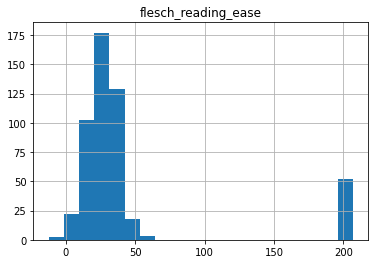

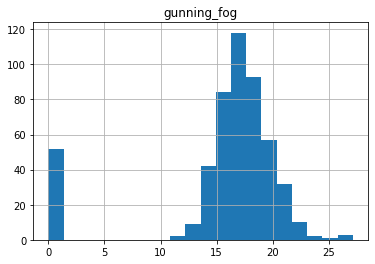

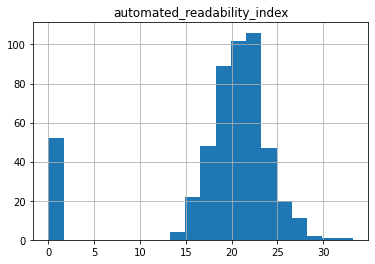

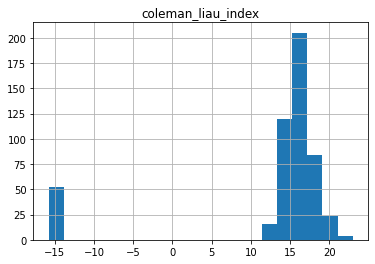

In [13]:
plotScores(stats)